In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                            accuracy_score, precision_score,
                            recall_score, f1_score, roc_auc_score)

In [2]:
df = pd.read_csv('diabetes.csv')

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

In [6]:
def get_metrics(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    print(f"\nМетрики для {model_name}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC-AUC: {auc:.4f}")

get_metrics(y_test, y_pred_lr, "логистической регрессии")
get_metrics(y_test, y_pred_dt, "решающего дерева")


Метрики для логистической регрессии:
Accuracy: 0.7143
Precision: 0.6087
Recall: 0.5185
F1-score: 0.5600
ROC-AUC: 0.6693

Метрики для решающего дерева:
Accuracy: 0.7273
Precision: 0.6429
Recall: 0.5000
F1-score: 0.5625
ROC-AUC: 0.6750


Несмотря на то, что обе модели показывают схожее качество, решающее дерево с параметрами по умолчанию демонстрирует немного лучшие результаты по большинству метрик. На этапе базового сравнения решающее дерево предпочтительнее, хотя разница невелика, но важно помнить о склонности к переобучению дерева.

Для нахождения лучшей глубины дерева я выбрал ROC_AUC, т.к она показывает, насколько хорошо модель разделяет классы на всех возможных порогах, особенно полезна в медицинских задачах, где важно улавливать и положительные, и отрицательные случаи. Хорошо работает при несбалансированности классов.

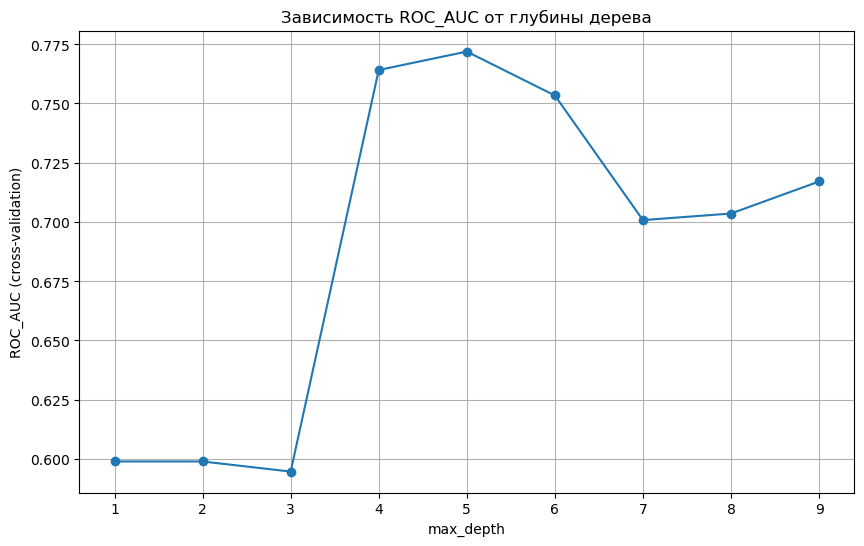


Оптимальная глубина: 5, ROC_AUC: 0.7719


In [13]:
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

max_depths = np.arange(1, 10)
roc_auc_scores = []

for d in max_depths:
    dt_temp = DecisionTreeClassifier(max_depth=d, random_state=42)
    dt_temp.fit(X_train, y_train)
    y_pred = dt_temp.predict(X_test)
    roc_auc_scores.append(roc_auc_score(y_test, y_pred))

plt.figure(figsize=(10,6))
plt.plot(max_depths, roc_auc_scores, marker='o')
plt.title('Зависимость ROC_AUC от глубины дерева')
plt.xlabel('max_depth')
plt.ylabel('ROC_AUC (cross-validation)')
plt.grid()
plt.show()

best_depth = max_depths[np.argmax(roc_auc_scores)]
best_roc_auc = max(roc_auc_scores)
print(f"\nОптимальная глубина: {best_depth}, ROC_AUC: {best_roc_auc:.4f}")

In [15]:
dt_opt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_opt.fit(X_train, y_train)

y_pred_opt = dt_opt.predict(X_test)
y_proba_opt = dt_opt.predict_proba(X_test)[:, 1]

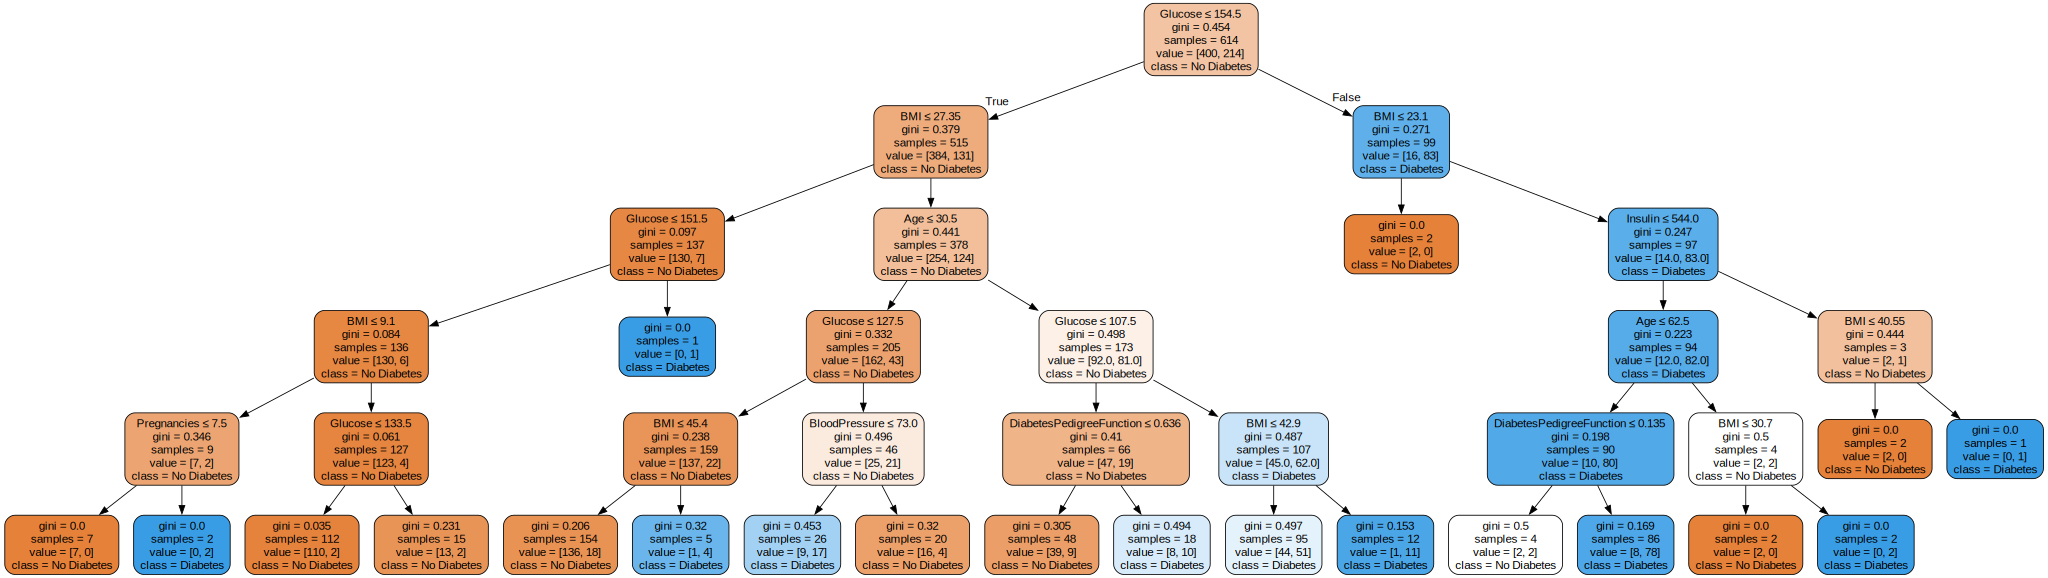

In [29]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(
    dt_opt,
    out_file=None,
    feature_names=X.columns,
    class_names=['No Diabetes', 'Diabetes'],
    filled=True,
    rounded=True,
    special_characters=True
)

graph = graphviz.Source(dot_data)
graph

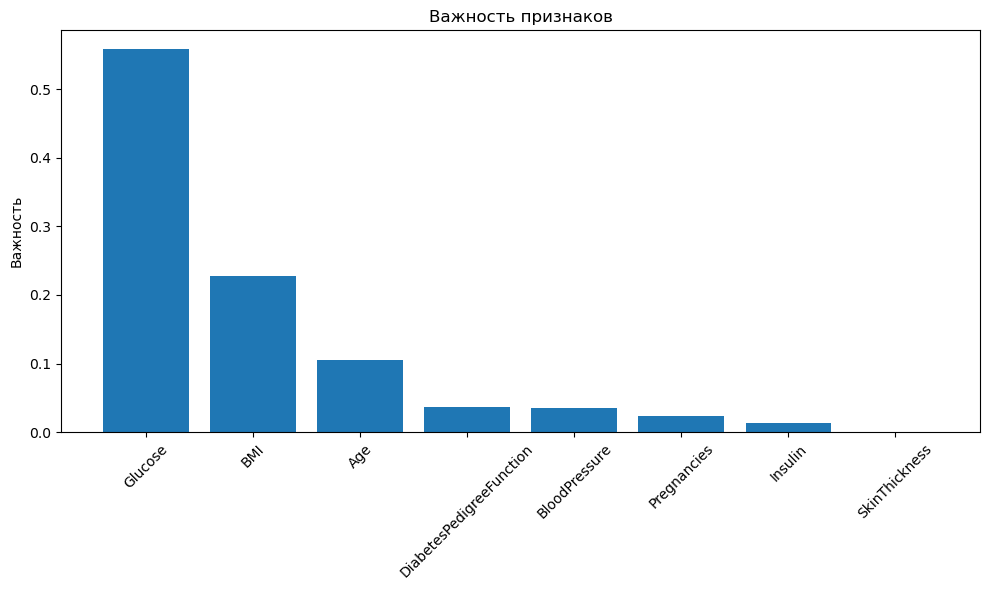

In [30]:
importances = dt_opt.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Важность признаков")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=45)
plt.ylabel("Важность")
plt.tight_layout()
plt.show()

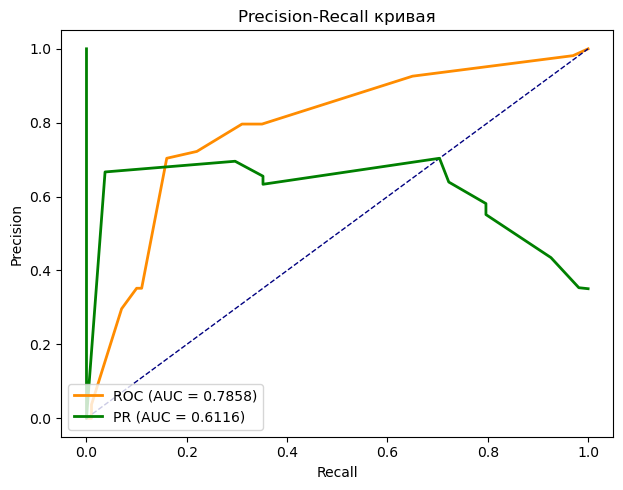

In [33]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_proba_opt)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(y_test, y_proba_opt)
pr_auc = auc(recall, precision)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")

plt.plot(recall, precision, color='green', lw=2, label=f'PR (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривая')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

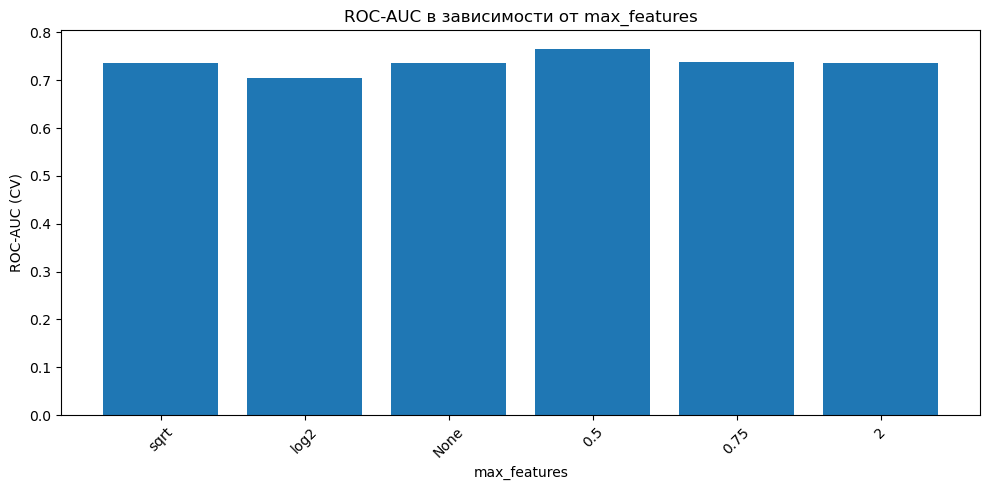

In [53]:
max_features_options = ['sqrt', 'log2', None, 0.5, 0.75, 2]
roc_scores_mf = []
for mf in max_features_options:
    model = DecisionTreeClassifier(max_depth=best_depth, max_features=mf, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    roc_scores_mf.append(score)

plt.figure(figsize=(10, 5))
plt.bar([str(m) for m in max_features_options], roc_scores_mf)
plt.title('ROC-AUC в зависимости от max_features')
plt.xlabel('max_features')
plt.ylabel('ROC-AUC (CV)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()